In [6]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [7]:
import pandas as pd
import os
from fastai import *
from fastai.vision import *

image_folder = '1024/image_dir_processed'

os.chdir("/home/auri/")
os.getcwd()

'/home/auri'

In [8]:
df = pd.read_csv('Rx-thorax-automatic-captioning/SJ_chest_x_ray_images_labels_160K_Ene19.csv', header = 0, dtype=str)
df.columns

Index(['Unnamed: 0', 'ImageID', 'ImageDir', 'StudyDate_DICOM', 'StudyID',
       'PatientID', 'PatientBirth', 'PatientSex_DICOM', 'ViewPosition_DICOM',
       'Projection', 'MethodProjection', 'Pediatric', 'Modality_DICOM',
       'Manufacturer_DICOM', 'PhotometricInterpretation_DICOM',
       'PixelRepresentation_DICOM', 'PixelAspectRatio_DICOM',
       'SpatialResolution_DICOM', 'BitsStored_DICOM', 'WindowCenter_DICOM',
       'WindowWidth_DICOM', 'Rows_DICOM', 'Columns_DICOM',
       'XRayTubeCurrent_DICOM', 'Exposure_DICOM', 'ExposureInuAs_DICOM',
       'ExposureTime', 'RelativeXRayExposure_DICOM', 'ReportID', 'Report',
       'MethodLabel', 'Labels', 'Localizations',
       'LabelsLocalizationsBySentence', 'labelCUIS', 'LocalizationsCUIS'],
      dtype='object')

In [9]:
#create field with labels flattened to a single sequence
import ast
def delabel(labels):
    r = None
    if labels is not None:
        try:
            r = pd.Series([label.strip() for label in  ast.literal_eval(labels)]).dropna().values
        except:
            r = None
    return r
    
df.loc[:,'labels'] = df.loc[:,'Labels'].apply(lambda l: delabel(l))

In [10]:
#create field with labels and locations  flattened to a single sequence
#uncomment only to train a model to predict both labels and locations
def delabel_loc(labels):
    r = None
    if labels is not None:
        try:
            r = pd.Series([label.replace('loc ','').strip() for sublist in  ast.literal_eval(labels) for label in sublist]).dropna().values
        except:
            r = None
    return r
    
#df.loc[:,'labelslocs'] = df.loc[:,'LabelsLocalizationsBySentence'].apply(lambda l: delabel_loc(l))

In [11]:
#Reports null are filtered (n = 103)
df_fastai = df.loc[df.labels.isna() == False,['ImageID','labels','Projection','Pediatric', 'StudyDate_DICOM', 'PatientBirth','MethodLabel']]
print(df_fastai.shape)

(160758, 7)


In [12]:
#corrupted images are filtered (n < 40)
corrupt_images = pd.read_csv('SJ/badfiles__.txt', dtype=str)
corrupt_images = corrupt_images.iloc[:,0].str.replace(image_folder,'').str.replace("'",'').values

df_fastai = df_fastai.loc[df_fastai.ImageID.isin(corrupt_images) == False,:]
df_fastai.shape

(160758, 7)

In [13]:
import glob
filter_images = pd.Series(glob.glob(f"/home/auri/SJ/{image_folder}/*.png")).str.replace(f'/home/auri/SJ/{image_folder}/','')
print(filter_images.describe())
df_fastai = df_fastai.loc[df_fastai.ImageID.isin(filter_images),]
df_fastai.shape

count                                                167257
unique                                               167257
top       216840111366964013402131755672012180122216672_...
freq                                                      1
dtype: object


(160725, 7)

In [14]:
#Pediatric images are filtered
df_fastai = df_fastai.loc[df_fastai['Pediatric'] != 'PED',]
print(df_fastai.shape)
df_fastai.head()

#In many pediatric images (n aprox 3300), none of the DICOM field are tagged as pediatric, so as an additional measure we remove patients less than 5 years old
#StudyDate_DICOM PatientBirth
df_fastai['age'] = df_fastai.StudyDate_DICOM.str.slice(0, 4).astype('float') - df_fastai.PatientBirth.astype('float') 

df_fastai =df_fastai.loc[df_fastai['age'] > 5.0,]
print(df_fastai.shape)

(160451, 7)
(157096, 8)


In [15]:
patho_list = ["atelectasis", "cardiomegaly", "cardiac", 
              "pleural effusion", "infiltrates", "mass", "nodule",
             "pneumonia", "pneumothorax", 
              "consolidation", "pulmonary edema",
             "emphysema", "pulmonary fibrosis", "pleural thickening",
             "hiatal hernia", "granuloma", "chronic changes", #scaring is not exactly equal to chronic changes, but more to fibrosis, but PLCO has other term with fibrosis
              "bone", "soft tissue",
             "COPD signs", "hilar", "normal"]

#Frontal images are selected
print(df_fastai.Projection.value_counts())
frontal = ['PA', 'AP_horizontal', 'AP']
df_fastai = df_fastai.loc[df_fastai['Projection'].isin(frontal),['ImageID','labels','Projection','Pediatric','MethodLabel']]
print(df_fastai.shape)


#"exclude" labeled reports  are filtered
df_fastai = df_fastai[~ df_fastai.labels.map(lambda x: 'exclude'  in x and x.shape[0] == 1)]
print(df_fastai.shape)

#"suboptimal study" reported images are filtered
df_fastai = df_fastai[~ df_fastai.labels.map(lambda x: 'suboptimal study'  in x and x.shape[0] == 1)]
print(df_fastai.shape)



#create new pandas with field "normal" True or False
normal = df_fastai[df_fastai.labels.map(lambda x: 'normal'  in x and x.shape[0] == 1)]
print(normal.shape)
df_fastai_normal = df_fastai[['ImageID','labels']]
df_fastai_normal.loc[:,'Normal'] = False
df_fastai_normal.loc[df_fastai.labels.map(lambda x: 'normal'  in x and x.shape[0] == 1),'Normal' ] = True

print(df_fastai_normal.head())


PA               90375
L                48956
AP_horizontal    13690
AP                3446
COSTAL             618
EXCLUDE             11
Name: Projection, dtype: int64
(107511, 5)
(106581, 5)
(106308, 5)
(34966, 5)


/home/auri/anaconda3/envs/fastai-Ene19/lib/python3.7/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/home/auri/anaconda3/envs/fastai-Ene19/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


                                             ImageID  \
0  20536686640136348236148679891455886468_k6ga29.png   
2  135803415504923515076821959678074435083_fzis7b...   
3  113855343774216031107737439268243531979_3k951l...   
5  313903302629300007485735352869488750471_75sg0k...   
7  3137231742710829928-247610802266403640553_kine...   

                                              labels  Normal  
0                                           [normal]    True  
2  [pulmonary fibrosis, chronic changes, kyphosis...   False  
3                                  [chronic changes]   False  
5  [unchanged, alveolar pattern, interstitial pat...   False  
7  [laminar atelectasis, pleural effusion, apical...   False  


In [16]:
#filter physician labeled
df_fastai_filter = df_fastai.loc[df_fastai.MethodLabel.isin(['Physician']), ['ImageID','labels']]
df_fastai_filter.reset_index(inplace = True, drop=True)
df_fastai_filter.head()


,ImageID,labels
0,20536686640136348236148679891455886468_k6ga29.png,[normal]
1,135803415504923515076821959678074435083_fzis7b...,"[pulmonary fibrosis, chronic changes, kyphosis..."
2,113855343774216031107737439268243531979_3k951l...,[chronic changes]
3,313903302629300007485735352869488750471_75sg0k...,"[unchanged, alveolar pattern, interstitial pat..."
4,3137231742710829928-247610802266403640553_kine...,"[laminar atelectasis, pleural effusion, apical..."


In [17]:
from sklearn.model_selection import train_test_split
train, val = train_test_split(df_fastai_filter, random_state=42, test_size=0.2, shuffle=True)

In [18]:
val

,ImageID,labels
12897,84706362718627566832176933474441160006_1v9461.png,[scoliosis]
8206,120199270506147287617168654477537973665_9yvn84...,[normal]
15063,30386231455685696725028069147833901400_p8e824.png,[normal]
1668,29776696218515980902287908064439351470_de509n.png,[normal]
8729,13748807095759886908824106083905444257_yo0nl2.png,"[scoliosis, COPD signs]"
24742,164833468521885228595178042947630858510_2_vhne...,"[kyphosis, bronchiectasis, sternotomy, emphyse..."
4421,84947146099796296850801274491558441473_r0z5o6.png,"[COPD signs, hilar enlargement]"
4685,195461176064340448274251704252327246960_24suly...,[normal]
24681,143653977337441981914402696485260243548_3wrlul...,"[sternotomy, suture material]"
13614,290851023748678637590882580047504223121_s8310b...,"[interstitial pattern, thoracic cage deformation]"


In [19]:
#remove instances from validation set that contains labels not present in training set
train_label_set = set([l for sublist in train.labels for l in sublist ])
val.loc[:,'label_set'] =  val.labels.apply(set)
val_r = val.loc[val.label_set <= train_label_set,]
print(val_r.shape)
print(val.shape)
val_idxs=val_r.index.values


(5159, 3)
(5160, 3)


In [20]:
import cv2
def open_png16(self, fn):
    img = cv2.imread(str(fn), cv2.IMREAD_UNCHANGED).astype(np.float32)/65535
    #img = cv2.resize(img, (224,224))
    return Image(torch.tensor(img).unsqueeze(0).expand((3,-1,-1)))
#open_png16(fn ="SJ/image_dir_processed/113855343774216031107737439268243531979_3k951l.png")

In [21]:
#Replace with the path to image folder 
p = "/home/auri/SJ/"
bach_size = 16

In [22]:
import cv2
class MyImageItemList(ImageItemList):
    def open(self,fn):
        img = None
        try:
            img = cv2.imread(str(fn), cv2.IMREAD_UNCHANGED).astype(np.float32)/65535
        except:
            print(fn)
        #img = cv2.resize(img, (224,224))
        return Image(torch.tensor(img).unsqueeze(0).expand((3,-1,-1)))

In [23]:
data = (MyImageItemList.from_df(
    df = df_fastai_filter, path = p, 
    folder=image_folder).split_by_idx(valid_idx=val_idxs).label_from_df(
    cols='labels').transform(
    get_transforms(do_flip = False, max_rotate = 5.0, max_zoom = 1.1, max_warp = None), 
    size=(1024,1024)).databunch(bs=bach_size).normalize())                          


In [30]:
print(val_idxs)

[12897  8206 15063  1668 ... 24825 24806  3353 19382]


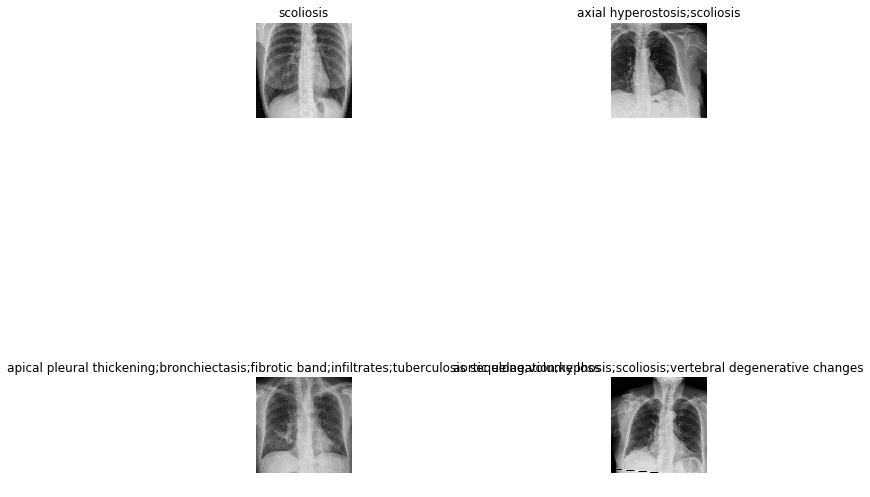

In [31]:
data.show_batch(rows=2, figsize=(10,10))


In [26]:
data.classes

['COPD signs',
 'Chilaiditi sign',
 'NSG tube',
 'abnormal foreign body',
 'abscess',
 'adenopathy',
 'air bronchogram',
 'air fluid level',
 'air trapping',
 'alveolar pattern',
 'aortic aneurysm',
 'aortic atheromatosis',
 'aortic button enlargement',
 'aortic elongation',
 'aortic endoprosthesis',
 'apical pleural thickening',
 'artificial aortic heart valve',
 'artificial heart valve',
 'artificial mitral heart valve',
 'asbestosis signs',
 'ascendent aortic elongation',
 'atelectasis',
 'atelectasis basal',
 'atypical pneumonia',
 'axial hyperostosis',
 'azygoesophageal recess shift',
 'azygos lobe',
 'blastic bone lesion',
 'bone cement',
 'bone metastasis',
 'breast mass',
 'bronchiectasis',
 'bronchovascular markings',
 'bullas',
 'calcified adenopathy',
 'calcified densities',
 'calcified fibroadenoma',
 'calcified granuloma',
 'calcified mediastinal adenopathy',
 'calcified pleural plaques',
 'calcified pleural thickening',
 'callus rib fracture',
 'cardiomegaly',
 'catheter'

aortic elongation;COPD signs;vertebral degenerative changes;hypoexpansion;scoliosis;infiltrates
ImageID    319473128845896878276703311554537838913_2fjh3z...
labels     [aortic elongation, COPD signs, vertebral dege...
Name: 24806, dtype: object


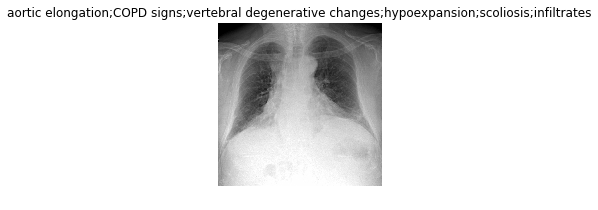

In [27]:
#show one study example from validation set
img,labels = data.valid_ds[-3]
print(labels)
print(df_fastai_filter.loc[val_idxs[-3],])
img.show(title=labels)


In [32]:
from fastai.imports import *
from sklearn.metrics import fbeta_score
import warnings
def f2(preds, targs, start=0.17, end=0.24, step=0.01):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        return torch.tensor(max([fbeta_score(targs, (preds>th), 2, average='samples')
                    for th in np.arange(start,end,step)]))
def f2_micro(preds, targs, start=0.17, end=0.24, step=0.01):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        return ([fbeta_score(targs, (preds>th), 2, average='micro')
                    for th in np.arange(start,end,step)])
def f2_macro(preds, targs, start=0.17, end=0.24, step=0.01):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        return ([fbeta_score(targs, (preds>th), 2, average='macro')
                    for th in np.arange(start,end,step)])
def f2_w(preds, targs, start=0.17, end=0.24, step=0.01):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        return ([fbeta_score(targs, (preds>th), 2, average='weighted')
                    for th in np.arange(start,end,step)])

In [40]:
acc_02 = partial(accuracy_thresh, thresh=0.2)
f_score = partial(fbeta, thresh=0.2, beta = 1)
f_score1 = partial(fbeta, thresh=0.1, beta = 1)
#metrics = listify([acc_02,f_score,f2_w, f_score1])
learn = create_cnn(data, 
                   models.resnet18,
                   metrics=[f_score, f_score1, acc_02]).to_fp16()#, f2_micro, f2_macro, f2_w])



LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


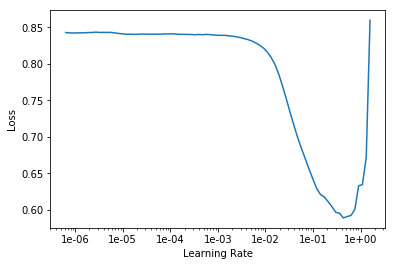

In [41]:

learn.lr_find()
learn.recorder.plot()

In [29]:
learn.unfreeze()

In [37]:
learn.fit_one_cycle(1, max_lr=1e-2)

epoch,train_loss,valid_loss,fbeta,fbeta,accuracy_thresh
1,0.038583,0.039912,0.399626,0.401488,0.986840


In [ ]:
learn.save('predict-0')

In [42]:
learn.load('predict-0')
1

1

In [123]:
lr = 1e-2
lrs = np.array([lr/9,lr/3,lr])
learn.unfreeze()
learn.fit_one_cycle(max_lr = lrs,  cyc_len=1)

epoch,train_loss,valid_loss,fbeta,fbeta,accuracy_thresh


KeyboardInterrupt: 

In [38]:
doc(create_cnn)

In [117]:
learn.unfreeze()


In [43]:
learn.lr_find()


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


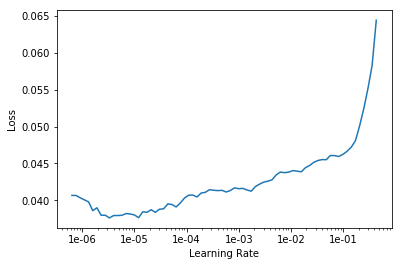

In [119]:
learn.recorder.plot()

In [120]:
learn.loss_func.func

BCEWithLogitsLoss()

In [44]:
learn.fit_one_cycle(1, max_lr=slice(1e-6,5e-6))

epoch,train_loss,valid_loss,fbeta,fbeta,accuracy_thresh
1,0.042263,0.039665,0.400475,0.401792,0.987067


In [45]:
preds,y,losses = learn.get_preds(with_loss=True)
interp = ClassificationInterpretation(data, preds, y, losses)


In [46]:
interp.plot_top_losses()

TypeError: plot_top_losses() missing 1 required positional argument: 'k'

In [47]:
interp.top_losses()


(tensor([1.0117e+01, 9.7891e+00, 9.6329e+00,  ..., 2.9802e-06, 2.7418e-06,
         2.7418e-06]),
 tensor([155264, 442169, 692378,  ..., 789846, 789789, 720605]))

In [48]:
cl = np.array(learn.data.valid_ds.y.classes)


ImageID    88538681912614728584037282641288377661_5_2nl6b...
labels     [chest drain tube, NSG tube, callus rib fractu...
Name: 16181, dtype: object
chest drain tube;NSG tube;callus rib fracture;rib fracture;pleural effusion
tensor(0.4517)
tensor(0.0254)


array(['NSG tube', 'alveolar pattern', 'central venous catheter via jugular vein', 'endotracheal tube',
       'pleural effusion', 'unchanged'], dtype='<U43')

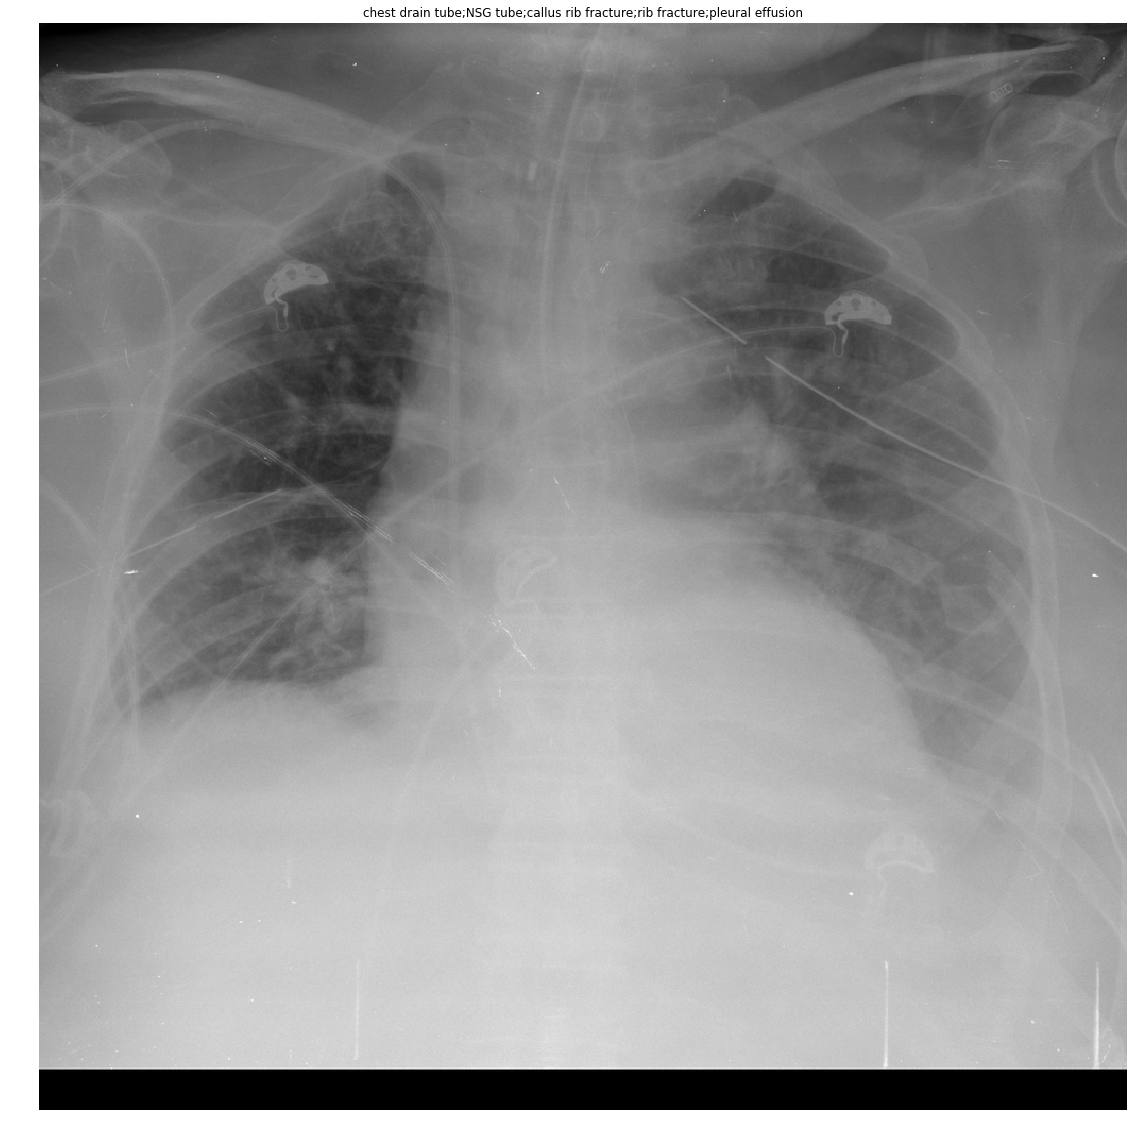

In [87]:
item = 32
img,labels = data.valid_ds[item]
img.show(title=labels, figsize=(20,20) )
print(df_fastai_filter.loc[val_idxs[item],])
print(labels)
p = np.where(preds[item] > 0.2, 1, 0)
print(preds[item].max())
print(losses[item])
#mask = np.array( y[0].numpy(), dtype= bool)
mask = np.array( p, dtype= bool)
cl[mask]


In [89]:
data.valid_ds

LabelList
y: MultiCategoryList (5159 items)
[MultiCategory scoliosis, MultiCategory normal, MultiCategory normal, MultiCategory normal, MultiCategory scoliosis;COPD signs]...
Path: /home/auri/SJ
x: MyImageItemList (5159 items)
[Image (3, 1036, 1024), Image (3, 1024, 1245), Image (3, 1024, 1213), Image (3, 1024, 1046), Image (3, 1024, 1245)]...
Path: /home/auri/SJ

In [ ]:
learn.lr_find()


In [ ]:
learn.recorder.plot()

In [ ]:
learn.save('stage-1')


In [ ]:
learn.load('stage-1')

In [ ]:
learn.lr_find()

In [ ]:
learn.recorder.plot()

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(1e-3,1e-2))